# 数据分析

数据分析的价值主要在于熟悉了解整个数据集的基本情况包括每个文件里有哪些数据，具体的文件中的每个字段表示什么实际含义，以及数据集中特征之间的相关性，在推荐场景下主要就是分析用户本身的基本属性，文章基本属性，以及用户和文章交互的一些分布，这些都有利于后面的召回策略的选择，以及特征工程。

建议：当特征工程和模型调参已经很难继续上分了，可以回来在重新从新的角度去分析这些数据，或许可以找到上分的灵感

## 1 导包

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='SimHei', size=13)

---

## 2 读取数据集

In [2]:
path = '../data/'

# 训练集
train_click = pd.read_csv(path + 'train_click_log.csv')
item_df = pd.read_csv(path + 'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  # 重命名，方便后续 match
item_emb_df = pd.read_csv(path + 'articles_emb.csv')

# 测试集
test_click = pd.read_csv(path + 'testA_click_log.csv')

---

## 3 数据预处理

计算用户点击rank和点击次数

In [3]:
# 对每个用户的点击时间戳进行排序
train_click['rank'] = train_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
test_click['rank'] = test_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [4]:
# 计算用户点击文章的次数，并添加新的一列count
train_click['click_cnt'] = train_click.groupby(['user_id'])['click_timestamp'].transform('count')
test_click['click_cnt'] = test_click.groupby(['user_id'])['click_timestamp'].transform('count')

---

## 4 数据浏览

### 4.1 用户点击日志文件训练集

In [5]:
train_click = train_click.merge(item_df, how='left', on=['click_article_id'])
train_click

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnt,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112618,33446,16346,1508212054157,4,3,2,1,25,1,1,4,7,1508181832000,215
1112619,0,30760,1508211672520,4,1,17,1,25,2,2,2,26,1508185091000,162
1112620,0,157507,1508211702520,4,1,17,1,25,2,1,2,281,1508236945000,370
1112621,199178,234481,1508211513583,4,3,2,1,25,2,2,14,375,1508181572000,212


train_click_log.csv文件数据中每个字段的含义

1. `user_id`: 用户的唯一标识
2. `click_article_id`: 用户点击的文章唯一标识
3. `click_timestamp`: 用户点击文章时的时间戳
4. `click_environment`: 用户点击文章的环境
5. `click_deviceGroup`: 用户点击文章的设备组
6. `click_os`: 用户点击文章时的操作系统
7. `click_country`: 用户点击文章时的所在的国家
8. `click_region`: 用户点击文章时所在的区域
9. `click_referrer_type`: 用户点击文章时，文章的来源

In [6]:
# 用户点击日志信息
train_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int32
 10  click_cnt            1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int32(1), int64(13)
memory usage: 114.6 MB


In [7]:
train_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnt,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [8]:
# 统计训练集中用户的数量
print('train_click 中用户数量:', train_click['user_id'].nunique())

train_click 中用户数量: 200000


In [9]:
# 训练集里面每个用户至少点击了两篇文章
train_click.groupby('user_id')['click_article_id'].count().min()

2

画直方图大体看一下基本的属性分布

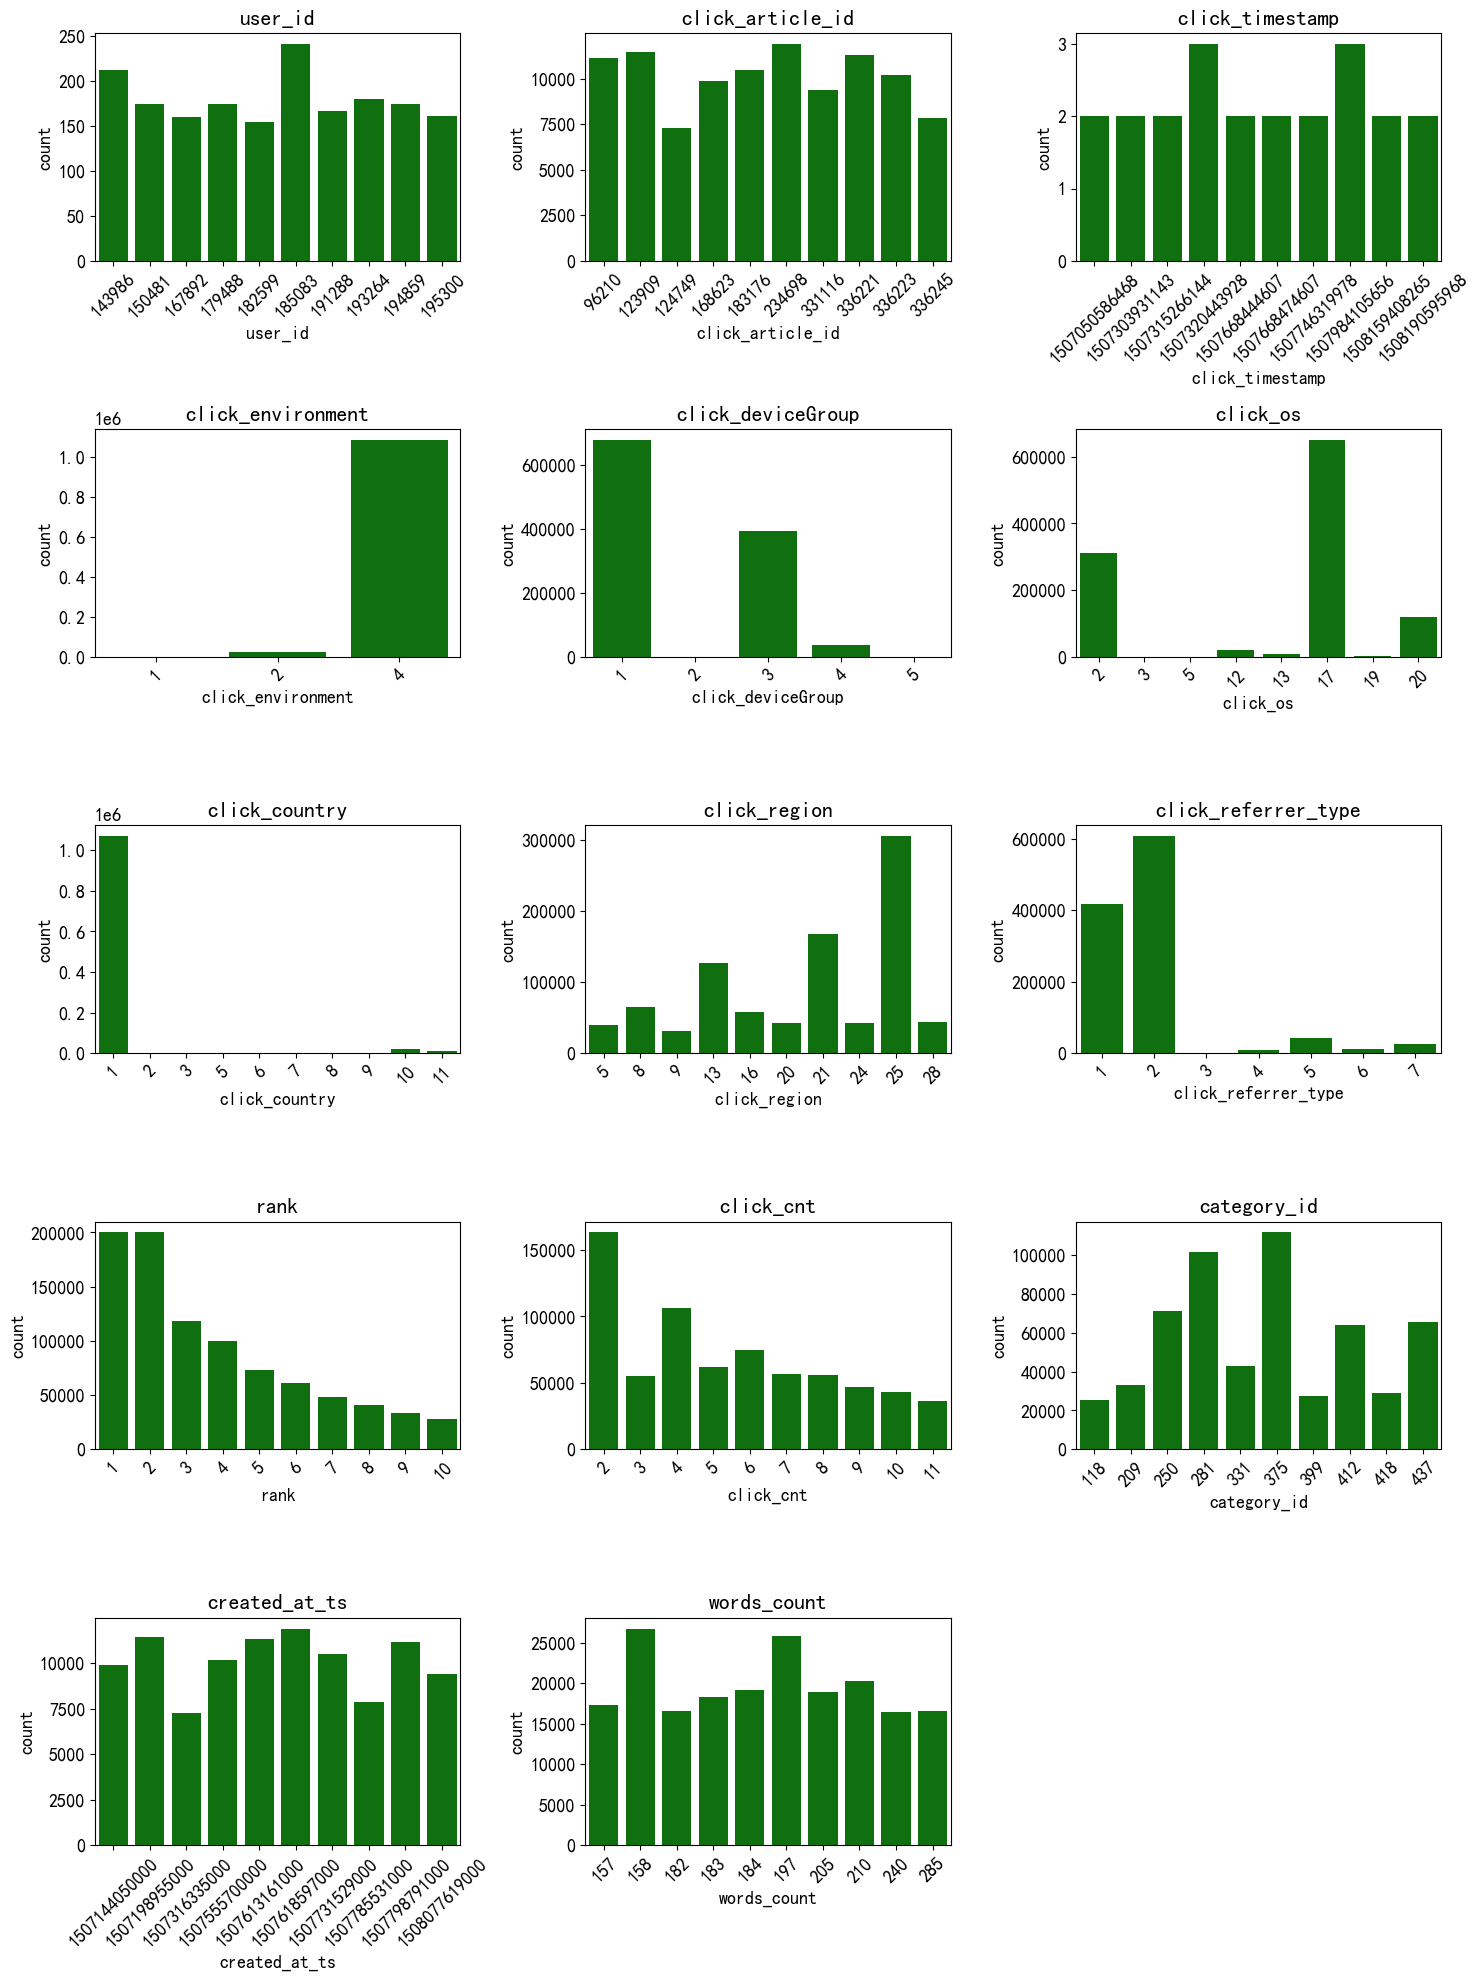

In [10]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(train_click.columns):
    plot_envs = plt.subplot(5, 3, i + 1)
    v = train_click[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v[col], y=v['count'], color='green')
    for item in fig.get_xticklabels():
        item.set_rotation(45)
    plt.title(col)
plt.tight_layout()

从点击时间clik_timestamp来看，分布较为平均，可不做特殊处理。由于时间戳是13位的，后续将时间格式转换成10位方便计算。

从点击环境click_environment来看，仅有1922次（占0.1%）点击环境为1；仅有24617次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4。

从点击设备组click_deviceGroup来看，设备1占大部分（60.4%），设备3占36%。

### 4.2 测试集用户点击日志


In [11]:
test_click = test_click.merge(item_df, how='left', on=['click_article_id'])
test_click

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnt,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518005,221924,70758,1508211323220,4,3,2,1,25,2,1,14,136,1508188164000,282
518006,207823,331116,1508211542618,4,3,2,1,25,1,4,14,436,1508077619000,144
518007,207823,234481,1508211850103,4,3,2,1,25,1,3,14,375,1508181572000,212
518008,207823,211442,1508212189949,4,3,2,1,25,1,2,14,340,1508187720000,240


In [12]:
test_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnt,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


In [13]:
print('test_click 中用户数量:', test_click['user_id'].nunique())

test_click 中用户数量: 50000


In [14]:
test_click.groupby('user_id')['click_article_id'].count().min() # 注意测试集里面有只点击过一次文章的用户

1

### 4.3 新闻文章信息数据表

In [15]:
# 新闻文章数据集浏览
item_df.head(), item_df.tail()

(   click_article_id  category_id  created_at_ts  words_count
 0                 0            0  1513144419000          168
 1                 1            1  1405341936000          189
 2                 2            1  1408667706000          250
 3                 3            1  1408468313000          230
 4                 4            1  1407071171000          162,
         click_article_id  category_id  created_at_ts  words_count
 364042            364042          460  1434034118000          144
 364043            364043          460  1434148472000          463
 364044            364044          460  1457974279000          177
 364045            364045          460  1515964737000          126
 364046            364046          460  1505811330000          479)

In [16]:
# words_count 是文章字数
item_df['words_count'].value_counts()

words_count
176     3485
182     3480
179     3463
178     3458
174     3456
        ... 
556        1
625        1
2798       1
767        1
841        1
Name: count, Length: 866, dtype: int64

文章主题个数: 461


(0           0
 1           1
 2           1
 3           1
 4           1
          ... 
 364042    460
 364043    460
 364044    460
 364045    460
 364046    460
 Name: category_id, Length: 364047, dtype: int64,
 <Axes: >)

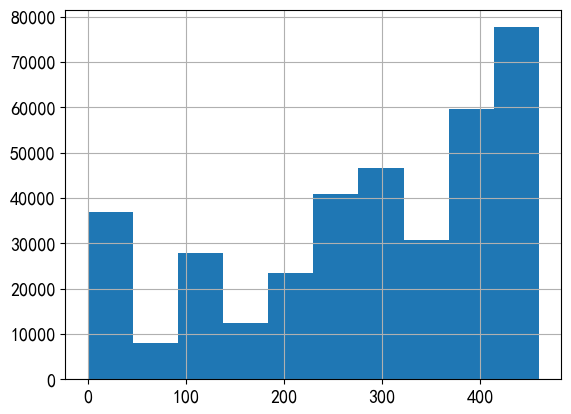

In [17]:
print('文章主题个数:', item_df['category_id'].nunique())
item_df['category_id'], item_df['category_id'].hist()

In [18]:
item_df.shape

(364047, 4)

### 4.4 新闻文章 embedding 向量表示

In [19]:
item_emb_df

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,...,-0.410550,0.564253,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,364043,-0.136932,-0.995471,0.991298,0.031871,-0.915621,-0.658517,0.633090,-0.564356,0.676551,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691554,-0.588281,0.902999,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726


In [20]:
item_emb_df.shape

(364047, 251)

In [21]:
item_emb_df.describe()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
count,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,...,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000
mean,182023.000000,-0.238645,-0.963334,0.118548,-0.279295,-0.068579,0.045945,-0.168319,-0.216564,-0.006810,...,-0.133287,-0.081912,-0.060347,0.023003,0.076947,0.084603,0.062819,0.099768,0.155917,-0.041094
std,105091.461061,0.451497,0.022651,0.495050,0.505067,0.506723,0.483288,0.514183,0.456211,0.519036,...,0.490597,0.449957,0.489498,0.507181,0.426143,0.467998,0.462678,0.499648,0.454356,0.458819
min,0.000000,-0.991183,-0.996455,-0.968431,-0.994966,-0.994489,-0.985974,-0.995090,-0.995926,-0.991316,...,-0.990412,-0.989408,-0.990432,-0.993626,-0.989042,-0.996902,-0.992921,-0.984733,-0.976071,-0.988213
25%,91011.500000,-0.620072,-0.974056,-0.289953,-0.718816,-0.503425,-0.354579,-0.610391,-0.604471,-0.446108,...,-0.547684,-0.445079,-0.479989,-0.404508,-0.248653,-0.267072,-0.306548,-0.313598,-0.201402,-0.420694
50%,182023.000000,-0.302581,-0.967605,0.124339,-0.391535,-0.093734,0.062636,-0.259313,-0.257692,-0.025777,...,-0.175781,-0.094113,-0.078034,0.000726,0.105649,0.133525,0.083315,0.128757,0.188355,-0.015232
75%,273034.500000,0.098015,-0.959061,0.545112,0.108320,0.345024,0.446979,0.244957,0.138783,0.432606,...,0.250641,0.270006,0.341105,0.459386,0.417347,0.461466,0.441831,0.531453,0.538111,0.334226
max,364046.000000,0.983694,-0.514728,0.998341,0.978092,0.996798,0.996343,0.990139,0.963327,0.992945,...,0.996401,0.981789,0.991332,0.995299,0.978823,0.989324,0.991445,0.997583,0.990507,0.968461


In [22]:
item_emb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 251 entries, article_id to emb_249
dtypes: float64(250), int64(1)
memory usage: 697.1 MB


---

## 5 数据分析

### 5.1 用户重复点击

In [23]:
user_click_merge = pd.concat([train_click, test_click])

# 用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'], as_index=False)['click_timestamp'].agg({'count'})
user_click_count

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
...,...,...,...
1617702,249999,299152,1
1617703,249999,301015,1
1617704,249999,313431,1
1617705,249999,336221,1


In [24]:
user_click_count[user_click_count['count'] > 10]

,user_id,click_article_id,count
576902,134850,69463,13


In [25]:
user_click_count['count'].unique(), user_click_count.shape

(array([ 1,  2,  4,  3,  6,  5, 10,  7, 13], dtype=int64), (1617707, 3))

<Axes: >

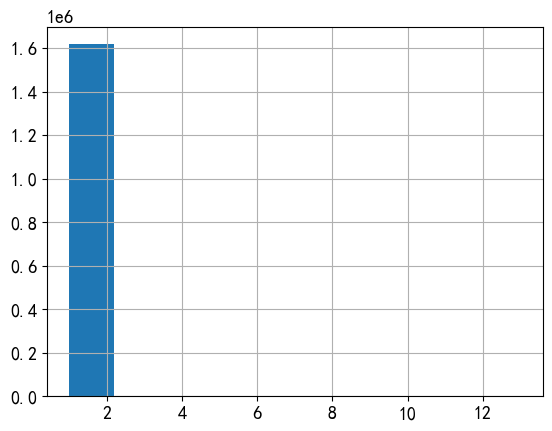

In [26]:
user_click_count['count'].hist()

In [27]:
user_click_count['count'].value_counts()

count
1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

可以看出：有1605541（约占99.2%）的用户未重复阅读过文章，仅有极少数用户重复点击过某篇文章，这个也可以单独制作成特征。

### 5.2 用户点击环境变化分析

In [28]:
user_click_env = user_click_merge.groupby(['user_id', 'click_environment'], as_index=False)['click_environment'].agg({'count'})
user_click_env

,user_id,click_environment,count
0,0,4,2
1,1,4,2
2,2,4,2
3,3,4,2
4,4,4,2
...,...,...,...
250870,249995,4,34
250871,249996,4,1
250872,249997,4,7
250873,249998,4,5


(array([  2,   3,   4,   5,   7,  14,   6,   1,  11,   9,   8,  12,  39,
         10,  16,  20,  13,  36,  33,  28,  22,  15,  94,  18,  19,  17,
         23,  21,  61,  24,  66,  25,  47,  27,  30,  31,  34,  26,  57,
         60,  32,  42,  29,  86,  51,  44,  40,  50,  67,  43,  48,  45,
         38,  75,  37, 102,  63,  49,  70,  41,  35,  55,  53,  59,  72,
         52,  73,  58,  69,  46,  78,  64, 135,  77,  81,  56,  62,  76,
        114,  97,  65,  87,  82, 103, 133,  74,  98,  54,  88,  89, 101,
        111,  79,  68,  85,  84, 121, 109, 212, 105, 175,  92,  95, 127,
        152, 104, 100,  93, 117, 160,  83,  71, 126,  91, 113, 134, 132,
         96,  80, 112, 118, 123, 154, 241, 107, 124, 167, 180,  90, 174,
        161, 130, 143, 116, 185, 148, 184, 125,  99, 191, 136, 119, 108,
        120, 110, 131, 106, 158, 155, 128, 137, 245, 157, 139, 219, 361,
        259, 138, 129, 782, 141, 190, 217, 326, 243, 168, 149, 156, 938,
        242], dtype=int64),
 (250875, 3),
 <Axes: >

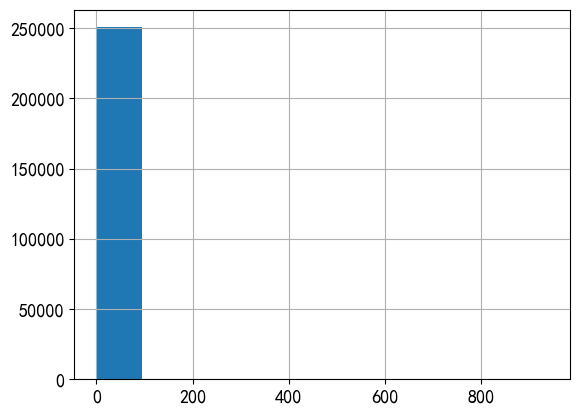

In [29]:
user_click_env['count'].unique(), user_click_env.shape, user_click_env['count'].hist()

In [30]:
user_click_env['count'].value_counts()

count
2      84545
4      29468
3      23851
5      15927
6      14928
       ...  
184        1
191        1
136        1
120        1
242        1
Name: count, Length: 170, dtype: int64

### 5.3 用户点击新闻数量的分布

In [31]:
def draw(df, x_label: str='', y_label: str=''):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(df)

In [32]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
min(user_click_item_count), max(user_click_item_count)

(1, 938)

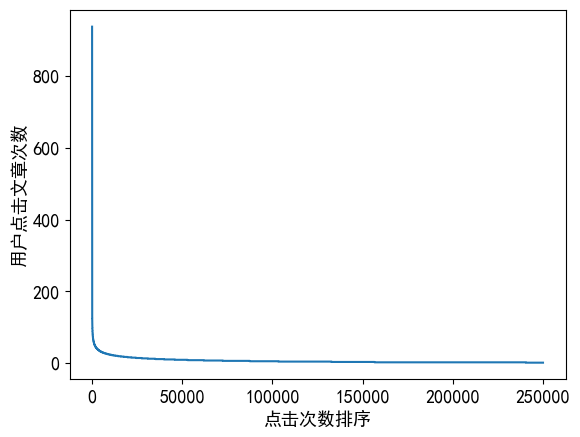

In [33]:
draw(user_click_item_count, '点击次数排序', '用户点击文章次数')

用户最多点击 938 次新闻，最少点击 1 次新闻。

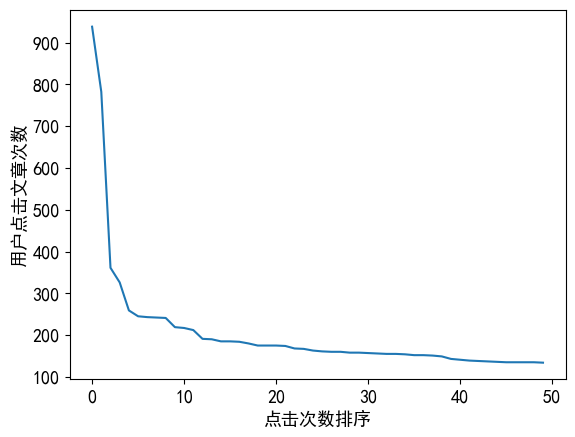

In [34]:
# 点击次数在前 50 的用户
draw(user_click_item_count[:50], '点击次数排序', '用户点击文章次数')

点击次数排前50的用户的点击次数都在100次以上。思路：我们可以定义点击次数大于等于100次的用户为活跃用户，这是一种简单的处理思路， 判断用户活跃度，更加全面的是再结合上点击时间，后面我们会基于点击次数和点击时间两个方面来判断用户活跃度。

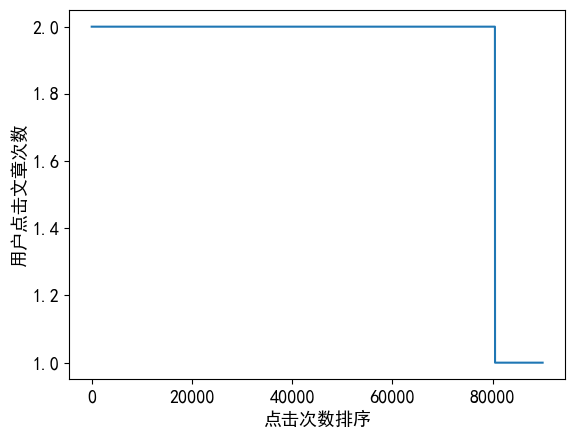

In [35]:
# 点击次数排名在 [160000: 250000] 之间的用户
draw(user_click_item_count[160000:], '点击次数排序', '用户点击文章次数')

可以看出点击次数小于等于两次的用户非常的多，这些用户可以认为是非活跃用户。

### 5.4 新闻点击次数分析

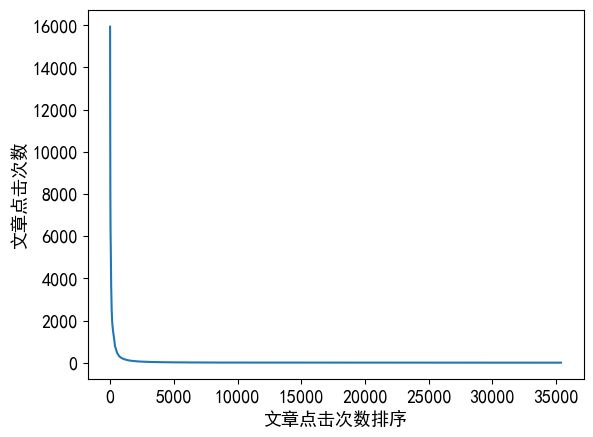

In [36]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)
draw(item_click_count, '文章点击次数排序', '文章点击次数')

In [50]:
tmp = user_click_merge.groupby('click_article_id', as_index=False)['user_id'].count()
tmp.rename(columns={'user_id': 'click_count'}, inplace=True)
df_b = item_df[['click_article_id', 'words_count']]
tmp = pd.merge(tmp, df_b, on='click_article_id', how='left')
tmp.sort_values(by='click_count', ascending=False, inplace=True)
tmp

,click_article_id,click_count,words_count
27001,272143,15935,184
23729,234698,15666,183
13520,123909,15383,240
33072,336221,15170,158
10674,96210,14009,274
...,...,...,...
15183,145276,1,213
15180,145271,1,215
15179,145270,1,149
15177,145260,1,171


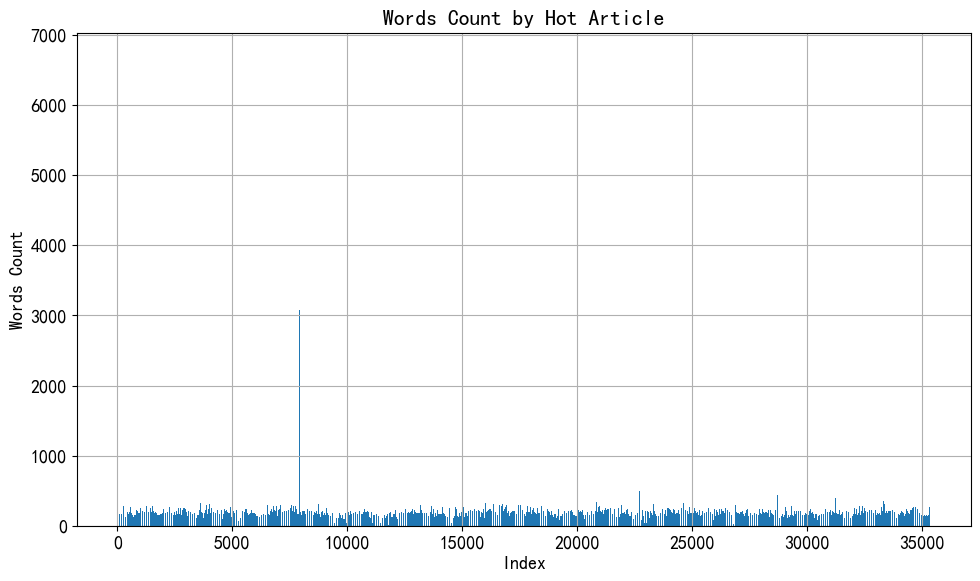

In [57]:
# 绘制图表
plt.figure(figsize=(10, 6))
plt.bar(tmp.index, tmp['words_count'])
plt.title('Words Count by Hot Article')
plt.xlabel('Index')
plt.ylabel('Words Count')
plt.grid()
plt.tight_layout()

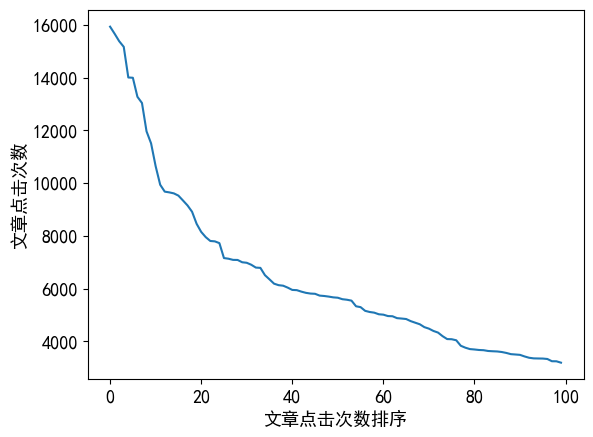

In [38]:
draw(item_click_count[:100], '文章点击次数排序', '文章点击次数')

In [39]:
item_click_count[20]

8155

可以看出点击次数最多的前 100 篇新闻，点击次数大于 3000 次。

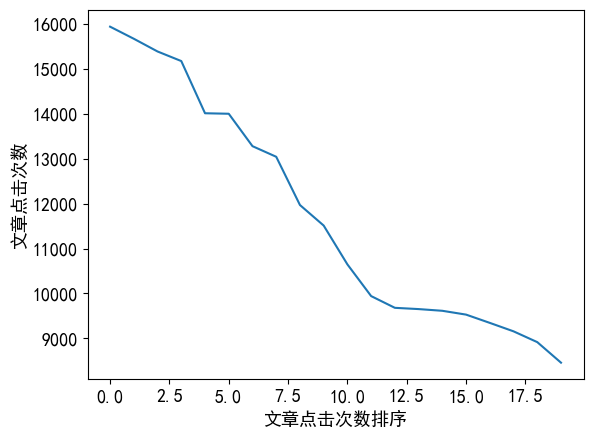

In [40]:
draw(item_click_count[:20], '文章点击次数排序', '文章点击次数')

点击次数最多的前 20 篇新闻，点击次数大于 8100。

思路：可以定义这些新闻为热门新闻， 这个也是简单的处理方式，后面我们也是根据点击次数和时间进行文章热度的一个划分。

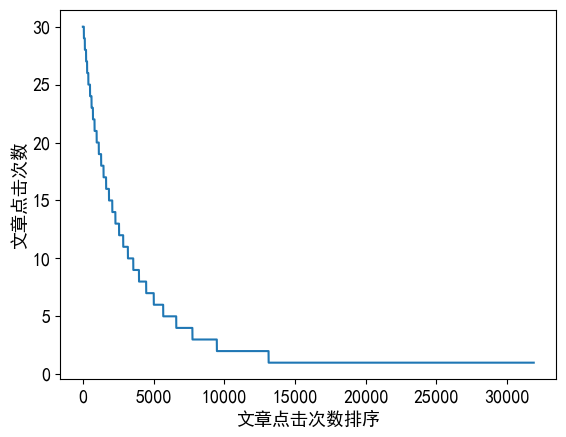

In [41]:
draw(item_click_count[3500:], '文章点击次数排序', '文章点击次数')

可以发现很多新闻只被点击过一两次，可以定义这些新闻是冷门新闻。

### 5.5 新闻共现频次：两篇新闻连续出现的次数

In [42]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x: x.shift(-1))
union_item = tmp.groupby(['click_article_id', 'next_item'], as_index=False)['click_timestamp'].agg({'count'})

In [46]:
union_item

,click_article_id,next_item,count
0,69,324774.0,1
1,84,123826.0,1
2,94,41376.0,1
3,137,285719.0,1
4,142,124228.0,1
...,...,...,...
433592,364043,99732.0,1
433593,364043,234536.0,1
433594,364043,236338.0,1
433595,364046,193104.0,1


In [42]:
union_item['count'].describe()

count    433597.000000
mean          3.184139
std          18.851753
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2202.000000
Name: count, dtype: float64

由统计数据可以看出，平均共现次数 3.18，最高为 2202。说明用户看的新闻，相关性是比较强的。

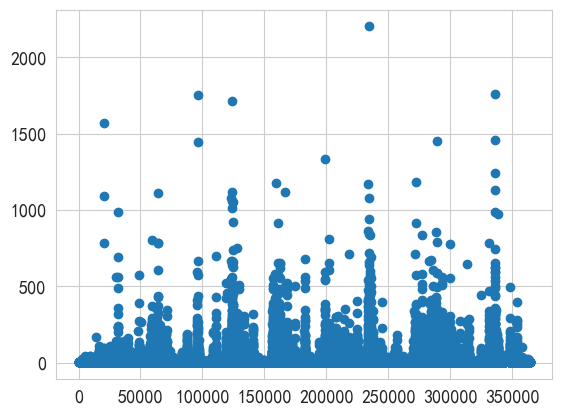

In [43]:
plt.scatter(x=union_item['click_article_id'], y=union_item['count'])

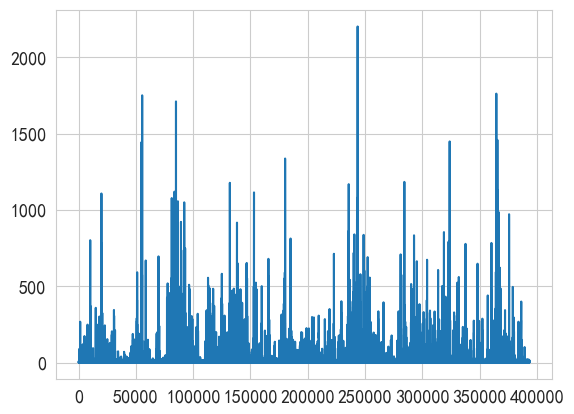

In [44]:
draw(union_item['count'].values[40000:])

### 5.6 新闻文章信息


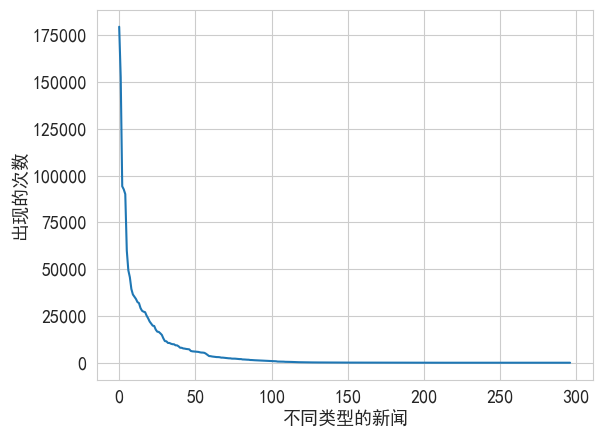

In [45]:
# 不同类型的新闻出现的次数
draw(user_click_merge['category_id'].value_counts().values, '不同类型的新闻', '出现的次数')

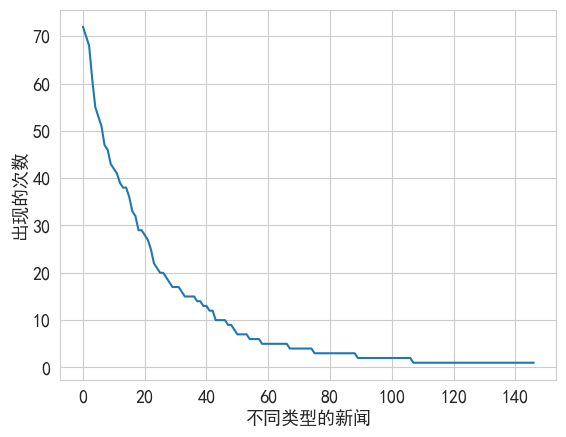

In [46]:
# 出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次
draw(user_click_merge['category_id'].value_counts().values[150:], '不同类型的新闻', '出现的次数')

In [47]:
# 新闻字数的描述性统计
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

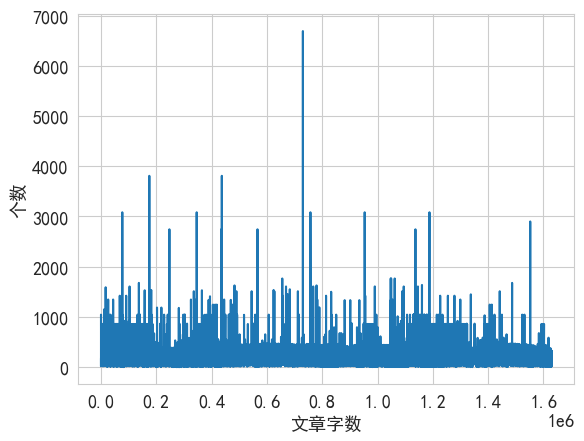

In [48]:
draw(user_click_merge['words_count'].values, '文章字数', '个数')

### 5.7 用户点击的新闻类型的偏好

此特征可以用于度量用户的兴趣是否广泛

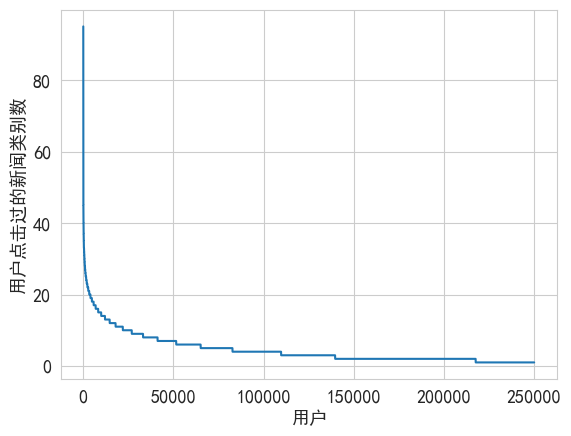

In [49]:
user_interest = sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True)
draw(user_interest, '用户', '用户点击过的新闻类别数')

从上图中可以看出有一小部分用户阅读类型是极其广泛的，大部分人都处在 20 个新闻类型以下。

In [50]:
user_click_merge.groupby('user_id', as_index=False)['category_id'].nunique().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


### 5.8 用户查看文章的长度的分布

通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣。

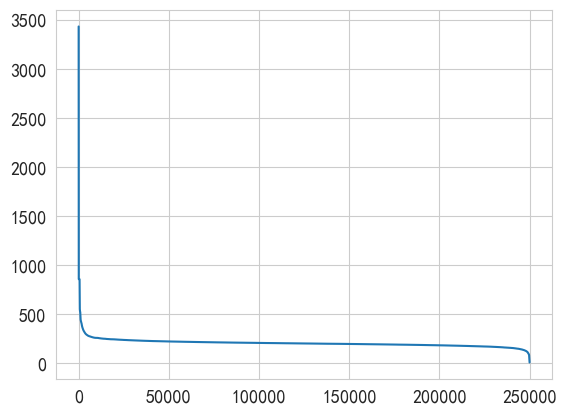

In [51]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))

从上图中可以发现有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低。

大多数人偏好于阅读字数在 200 ~ 400 字之间的新闻。

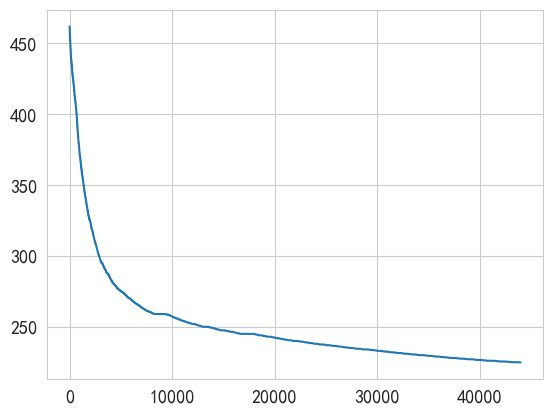

In [52]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])

可以发现大多数人都是看 250 字以下的文章。

In [ ]:
# 更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


### 5.9 用户点击新闻的时间分析

In [54]:
# 为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])
user_click_merge = user_click_merge.sort_values('click_timestamp')
user_click_merge['click_timestamp']

18         0.000000
2          0.000002
30         0.000003
50         0.000004
25         0.000004
             ...   
705656     0.779105
925954     0.860177
925955     0.860185
1091177    0.999992
1091178    1.000000
Name: click_timestamp, Length: 1630633, dtype: float64

In [55]:
user_click_merge['click_timestamp'].describe()

count    1.630633e+06
mean     1.550181e-01
std      9.875285e-02
min      0.000000e+00
25%      7.103479e-02
50%      1.655782e-01
75%      2.217570e-01
max      1.000000e+00
Name: click_timestamp, dtype: float64

In [76]:
def mean_diff_time_func(df, col):
    """
    计算给定列的时间差的平均值。
    
    Args:
        df(`DataFrame`): 包含需要计算时间差的列的 DataFrame
        col(`str`): 要计算时间差的列名

    Returns:
        float: 给定列相邻元素之间时间差的平均值。
    """
    # 创建一个新的 DataFrame，只包含指定的列
    df = pd.DataFrame(df, columns=[col])
    
    # 创建一个新列 'time_shift1'，将指定列向下移动一行，填充前一个值为 0
    df['time_shift1'] = df[col].shift(1).fillna(0)
    
    # 计算当前时间戳与前一个时间戳之间的绝对差值
    df['diff_time'] = abs(df[col] - df['time_shift1'])
    
    # 返回时间差的平均值
    return df['diff_time'].mean()

In [68]:
# 点击时间差的平均值
mean_diff_click_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'click_timestamp'))

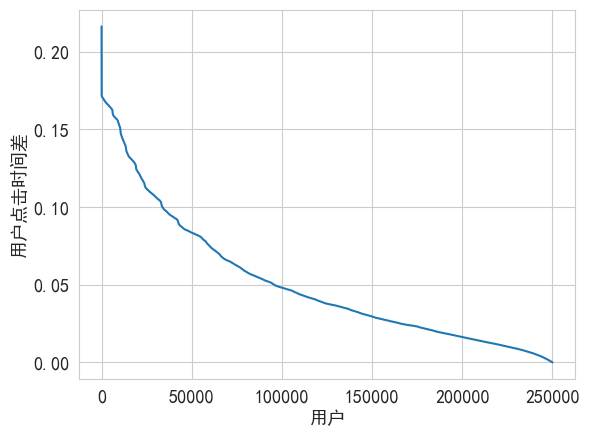

In [73]:
draw(sorted(mean_diff_click_time.values, reverse=True), x_label='用户', y_label='用户点击时间差')

从上图可以发现不同用户点击文章的时间差是有差异的。

In [79]:
# 前后点击文章的创建时间差的平均值
mean_diff_created_time = user_click_merge.groupby('user_id')[['click_timestamp', 'created_at_ts']].apply(lambda x: mean_diff_time_func(x, 'created_at_ts'))

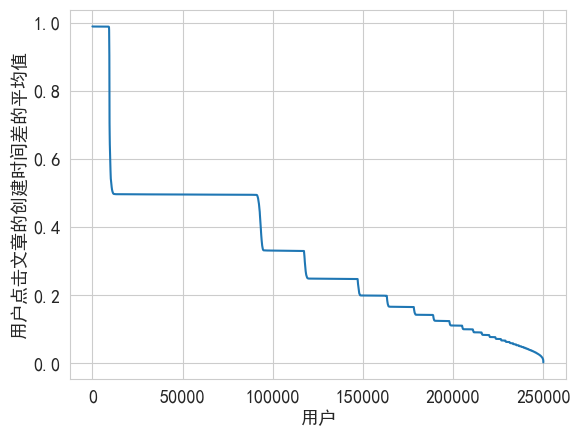

In [80]:
draw(sorted(mean_diff_created_time.values, reverse=True), x_label='用户', y_label='用户点击文章的创建时间差的平均值')

从图中可以发现用户先后点击文章，文章的创建时间也是有差异的。

In [83]:
# 用户前后点击文章的相似性分布
item_idx_2_rawid_dict = dict(zip(item_emb_df['article_id'], item_emb_df.index))
item_idx_2_rawid_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59,
 60: 60,
 61: 61,
 62: 62,
 63: 63,
 64: 64,
 65: 65,
 66: 66,
 67: 67,
 68: 68,
 69: 69,
 70: 70,
 71: 71,
 72: 72,
 73: 73,
 74: 74,
 75: 75,
 76: 76,
 77: 77,
 78: 78,
 79: 79,
 80: 80,
 81: 81,
 82: 82,
 83: 83,
 84: 84,
 85: 85,
 86: 86,
 87: 87,
 88: 88,
 89: 89,
 90: 90,
 91: 91,
 92: 92,
 93: 93,
 94: 94,
 95: 95,
 96: 96,
 97: 97,
 98: 98,
 99: 99,
 100: 100,
 101: 101,
 102: 102,
 103: 103,
 104: 104,
 105: 105,
 106: 106,
 107: 107,
 108: 108,
 109: 109,
 110: 110,

In [86]:
del item_emb_df['article_id']

KeyError: 'article_id'

In [85]:
# np.ascontiguousarray 是 NumPy 的一个函数，用于将输入数组转换为一个连续的数组
item_emb_np = np.ascontiguousarray(item_emb_df.values, dtype=np.float32)
item_emb_np

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

随机选择 5个用户，查看这些用户前后查看文章的相似性。

In [92]:
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnt,category_id,created_at_ts,words_count
47701,231890,162655,0.004431,4,3,2,1,21,2,6,6,281,0.989199,245
47702,231890,158536,0.004476,4,3,2,1,21,1,5,6,281,0.989112,858
47703,231890,160974,0.004484,4,3,2,1,21,1,4,6,281,0.989092,259
102984,211727,175040,0.009201,4,1,17,1,13,2,4,4,299,0.989273,176
102985,211727,272143,0.009209,4,1,17,1,13,2,3,4,399,0.989235,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088442,198306,159652,0.335316,4,1,17,1,21,1,5,36,281,0.992589,219
1097276,198306,277107,0.337637,4,1,17,1,21,1,4,36,409,0.992699,144
1097277,198306,158158,0.337764,4,1,17,1,21,1,3,36,281,0.992758,260
1097278,198306,235808,0.338300,4,1,17,1,21,1,2,36,375,0.992768,287


In [98]:
def get_item_sim_list(df):
    """
    计算相邻点击文章之间的余弦相似度列表。
    
    Args:
        df(`pd.DataFrame`): 包含用户点击文章 ID 的 DataFrame

    Returns:
        list: 包含相邻文章之间的余弦相似度的列表
    """
    sim_list = []  # 初始化相似度列表
    item_list = df['click_article_id'].values  # 获取文章 ID 列表

    # 遍历每一对相邻的文章 ID
    for i in range(0, len(item_list) - 1):
        # 获取当前和下一个文章的嵌入向量
        emb1 = item_emb_np[item_idx_2_rawid_dict[item_list[i]]]
        emb2 = item_emb_np[item_idx_2_rawid_dict[item_list[i + 1]]]
        # 计算余弦相似度
        cosine_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        # 将相似度添加到列表
        sim_list.append(cosine_sim)

    sim_list.append(0)  # 在列表末尾添加 0 以表示最后一对文章的相似度
    return sim_list  # 返回相似度列表

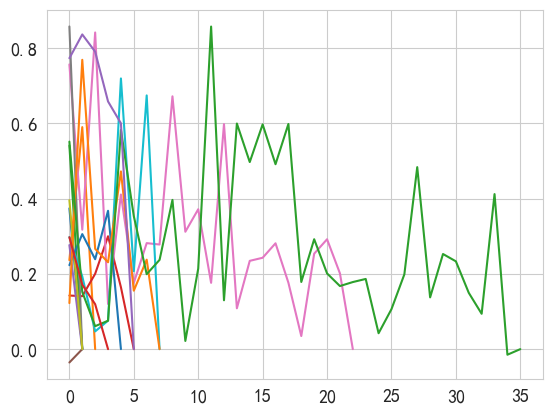

In [94]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)

从图中可以看出有些用户前后看的商品的相似度波动比较大，有些波动比较小，也是有一定的区分度的。

---

## 6 总结

通过数据分析的过程， 我们目前可以得到以下几点重要的信息， 这个对于我们进行后面的特征制作和分析非常有帮助：

1. 训练集和测试集的用户 id 没有重复，也就是测试集里面的用户没有模型是没有见过的
2. 训练集中用户最少的点击文章数是 2，而测试集里面用户最少的点击文章数是 1
3. 用户对于文章存在重复点击的情况，但这个都存在于训练集里面
4. 同一用户的点击环境存在不唯一的情况，后面做这部分特征的时候可以采用统计特征
5. 用户点击文章的次数有很大的区分度，后面可以根据这个制作衡量用户活跃度的特征
6. 文章被用户点击的次数也有很大的区分度，后面可以根据这个制作衡量文章热度的特征
7. 用户看的新闻，相关性是比较强的，所以往往我们判断用户是否对某篇文章感兴趣的时候，在很大程度上会和他历史点击过的文章有关
8. 用户点击的文章字数有比较大的区别，这个可以反映用户对于文章字数的区别
9. 用户点击过的文章主题也有很大的区别，这个可以反映用户的主题偏好 
10. 不同用户点击文章的时间差也会有所区别，这个可以反映用户对于文章时效性的偏好

所以根据上面的一些分析，可以更好的帮助我们后面做好特征工程，充分挖掘数据的隐含信息。
